In [64]:
## OPEN AI

path_data_files = "../cleaned_data/"
path_figures = "/Users/garci061/Dropbox/Apps/Overleaf/2022_rumor_final/Figures/"
import pandas as pd
import seaborn as sns
import pylab as plt

import json

def process_embedding(name="openai", vectorized=False):
    # Read data
    results = pd.read_csv(f'{path_data_files}/cleaned_combined_data.csv')

    # Original stimuly
    story_original = "Through history, most people didn't die of cancer or heart disease, the lifestyle diseases that are common in the Western world today. This is mostly because people didn't live long enough to develop them. They died of injuries -- being gored by an ox, shot on a battlefield, crushed in one of the new factories of the Industrial Revolution -- and most of the time from infection, which followed those injuries.\n\nThat changed when antibiotics were discovered. In 1928, Alexander Fleming discovered penicillin, a drug still used today to fight bacterial infections. Suddenly, infections that had been a death sentence became remedied within days. During World War II, this drug treated pneumonia and sepsis, and has been estimated to have saved between 12-15% of Allied Forces lives. We have been living inside the golden epoch of the miracle drugs, and now, we are coming to an end of it.\n\nPeople are dying of infections again because of a phenomenon called antibiotic resistance, or popularly referred to as “superbugs”. Bacteria compete against each other for resources, for food, by manufacturing lethal compounds that they direct against each other. When we first made antibiotics, we took those compounds into the lab and made our own versions of them, and bacteria responded to our attack the way they always had.\n\nFor 70 years, we played a game of leapfrog -- our drug and their resistance, and then another drug, and then resistance again -- and now the game is ending. Bacteria develop resistance so quickly that pharmaceutical companies have decided making antibiotics is not in their best interest, so there are infections moving across the world for which, out of the more than 100 antibiotics available on the market, two drugs might work with side effects, or one drug, or none.\n\nIt would be natural to hope that these infections are extraordinary cases, but in fact, in the United States and Europe, 50 thousand people a year die of infections which no drugs can help. A project chartered by the British government known as the Review on Antimicrobial Resistance estimates that the worldwide toll right now is 700 thousand deaths a year. Also, if we can't get this under control by 2050, the worldwide toll will be 10 million deaths a year (more than the current population of New York City).\n\nThe scale of antibiotic resistance seems overwhelming, but if you've ever bought a fluorescent light bulb because you were concerned about climate change, you already know what it feels like to take a tiny step to address an overwhelming problem. We could take those kinds of steps for antibiotic use too. We could forgo giving an antibiotic for our kids’ ear infection, if we're not sure it's the right one. And we could promise each other to never again to buy chicken or shrimp or fruit raised with routine antibiotic use. If we did those things, we could slow down the arrival of the post-antibiotic world."
    story_original = story_original.replace("\n"," ")
    stories = pd.DataFrame([story_original] + list(results["story_merged"].unique()))
    stories[0] = stories[0].str.replace("\n", " ")
    
    # get embeddings and save
    if vectorized:
        emb = get_embedding(stories[0])
        stories['ada_embedding'] = emb.numpy().tolist()
    else:
        emb = stories[0].apply(lambda x: get_embedding(x))
        stories['ada_embedding'] = emb
    
    str_to_emb = stories.set_index(0)["ada_embedding"].to_dict()
    json.dump(str_to_emb, open(f'./data_embedding/results_{name}_embeddings.json', "w+"))

## Open AI ADA 002
if 0:
    import openai
    openai.organization = "org-rhkfqeCc3Zj0yfiYwyqp3XNN"
    with open("openaiapi.key") as f:
        openai.api_key = f.read().strip()

    def get_embedding(text, model="text-embedding-ada-002"):
        return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

    process_embedding(name="openai", vectorized=False)

## GOOGLE UNIVERSAL ENCODER
if 0:
    #Where to save the model (very large)
    path_model = "/Users/garci061/tmp"
    
    # Download the module, and uncompress it to the destination folder. 
    #!curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/5?tf-hub-format=compressed" | tar -zxvC $path_model/th5
    
    import tensorflow_hub as hub
    import numpy as np
    #Load model (can be loaded directly from the url above, but it's slow (500Mb))
    model = hub.load(path_model+"/th5")
    def get_embedding(input):
        return model(input)
    
    
    process_embedding(name="google_encoder", vectorized=True)

In [62]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom":
    False,"lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": False, "xtick.labelcolor": "#484848", "ytick.labelcolor":
    "#484848", "xtick.color": "#484848", "ytick.color": "#484848","text.color": "#484848", "axes.labelcolor": "#484848",
    "axes.titlecolor":"#484848","figure.figsize": [5,3],
    "axes.titlelocation":"left","xaxis.labellocation":"left","yaxis.labellocation":"bottom"}
palette = ["#3d348b","#e6af2e","#191716","#e0e2db"] #use your favourite colours
sns.set_theme(context='paper', style='white', palette=palette, font='Verdana', font_scale=1.3, color_codes=True,
rc=custom_params)

In [12]:
def set_style(name,xlabel="Layer number"):
    plt.xlabel(xlabel)
    plt.ylabel(name)
    plt.grid("on")
    plt.rc('axes', linewidth=2)
    plt.gca().grid(axis='x')
    
    sns.despine(left=True, bottom=True)
    plt.legend(loc=1, frameon=False, ncol=2)

def story2set(story,create_set=True,stop_words={}):
    if isinstance(story,float):
        return np.NaN
    else:
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in story.lower().split() if w not in stop_words]
        # remove empty 
        stripped = [w for w in stripped if len(w) > 0]
        
        
        if create_set:
            return set(stripped)
        else:
            return stripped

def jaccard(strs):
    str1,str2 = strs
    if isinstance(str1,float) or isinstance(str2,float):
        return np.NaN
    return len(str1 & str2)/ len(str1 | str2)

def propagation(strs):
    str1,str2,str3 = strs
    if isinstance(str1,float) or isinstance(str2,float)  or isinstance(str3,float):
        return np.NaN
    return len(str1&str2&str3)/len(str1|str2|str3)

def inference(strs):    
    str1,str2,str3 = strs
    if isinstance(str1,float) or isinstance(str2,float)  or isinstance(str3,float):
        return np.NaN
    return len((str3-str1)-str2)/len(str1|str2|str3)


def forgetting(strs):    
    str1,str2,str3 = strs
    if isinstance(str1,float) or isinstance(str2,float)  or isinstance(str3,float):
        return np.NaN
    return len((str1&str2)-str3)/len(str1|str2|str3)
    
def union(strs):
    str1,str2,str3 = strs
    if isinstance(str1,float) or isinstance(str2,float)  or isinstance(str3,float):
        return np.NaN

    return (len(str3&(str1-str2))+len(str3&(str2-str1)))/len(str1|str2|str3)
    
    

def create_similarity(data,jaccard=jaccard,create_set=True,stop_words={},tokenize=True):
    """
    Calculate Jaccard index with previous stories
    """
    #Add original story
    data["story_original"] = story_original
    
    if tokenize:
        for col in ["story1","story2","story3","story_merged","story_original"]:
            data.loc[:,col] = data.loc[:,col].apply(story2set,create_set=create_set,stop_words=stop_words)
    
    
    #Similarity with story1
    data["jaccard_1"] = data[["story1","story_merged"]].apply(jaccard,axis=1)
    #Similarity with story2
    data["jaccard_2"] = data[["story2","story_merged"]].apply(jaccard,axis=1)
    #Similarity with story2
    data["jaccard_3"] = data[["story3","story_merged"]].apply(jaccard,axis=1)
    #Average similarity with previous layer
    data["jaccard_previous_layer"] = data[["jaccard_1","jaccard_2","jaccard_3"]].max(1)
    #Similarity with story_original
    data["jaccard_original_story"] = data[["story_merged","story_original"]].apply(jaccard,axis=1)

    #With original story
    data["jaccard_os_1"] = data[["story1","story_original"]].apply(jaccard,axis=1)
    data["jaccard_os_2"] = data[["story2","story_original"]].apply(jaccard,axis=1)
    data["jaccard_os_3"] = data[["story3","story_original"]].apply(jaccard,axis=1)
    

    #Similariry within layer
    data["jaccard_wl_12"] = data[["story1","story2"]].apply(jaccard,axis=1)
    data["jaccard_wl_13"] = data[["story1","story3"]].apply(jaccard,axis=1)
    data["jaccard_wl_23"] = data[["story2","story3"]].apply(jaccard,axis=1)
    data["jaccard_within_layer"] = data[["jaccard_wl_12","jaccard_wl_13","jaccard_wl_23"]].mean(1)

    return data


def create_interactions(data):
    """
    Find motifs 
    """
    
    data["propagation"] =data[["story1","story2","story_merged"]].apply(propagation,axis=1)
    data["inference"] =data[["story1","story2","story_merged"]].apply(inference,axis=1)
    data["forgetting"] =data[["story1","story2","story_merged"]].apply(forgetting,axis=1)
    data["union"] =data[["story1","story2","story_merged"]].apply(union,axis=1)
    return data
    
    
    
def create_similarity_indep_replicates(results, sim_function=jaccard):

    av_jac = lambda x: [sim_function(stories) for stories in list(itertools.combinations(x,2))]
    results = results.sort_values(by=["condition","rep"], ascending=False)
    results["k"] = results.index%3
    results.loc[results["condition"].str.contains("chain"),"k"] = 0

    r = results.groupby(["condition","layer_n","k"])["story_merged"].agg(av_jac).reset_index()
    r = r.explode("story_merged").sort_values(by="condition")
    # # r = r.groupby(["condition","layer_n"]).mean().reset_index()
    r["story_merged"] = r["story_merged"].astype(float)
    
    r = r.reset_index(drop=True)
    return r
    
def plot_similarity_indep_replicates(r, ax=None):
    #g = sns.pointplot(x="layer_n",y="story_merged",hue="condition",data=r,lw=2,s=10,
                 #hue_order=conditions,palette=cond2color,ax=ax)
    #plt.setp(g.lines, alpha=0.3)

    sns.lineplot(x="layer_n",y="story_merged",hue="condition",
             palette=cond2color, data=r,lw=2,marker="o",markersize=7)
    
    set_style("Similarity between independent stories")
    
def main_similarity_indep_replicates(results, sim_function=jaccard, ax=None):
    r = create_similarity_indep_replicates(results, sim_function=sim_function)
    
    plot_similarity_indep_replicates(r, ax=ax)
    return r
    
    

def transformer_similarity(sentence1, sentence2, model):
    global global_emb
    
    if sentence1 in global_emb:
        embeddings1 = global_emb[sentence1]
    else:
        embeddings1 = model.encode([sentence1], convert_to_tensor=True)
        global_emb[sentence1] = embeddings1
    
    if sentence2 in global_emb:
        embeddings2 = global_emb[sentence2]
    else:
        embeddings2 = model.encode([sentence2], convert_to_tensor=True)
        global_emb[sentence2] = embeddings2
    
    
    #Compute cosine-similarits
    return float(util.pytorch_cos_sim(embeddings1, embeddings2)[0][0])

def plot_agg(data, x, y, hue):
    for cond, dt in data.groupby(hue):
        for rep, dt_rep in dt.groupby("rep"):
            if cond == "Network":
                dt_rep = dt_rep.groupby(x).mean(numeric_only=True).reset_index()
            plt.plot(dt_rep[x], dt_rep[y], "--", color=cond2color[cond], alpha=0.2)
                


# Robustness figures

In [13]:
cond2color = {
             "Chain":"#e6af2e",
            "chain_t":"red",
            "Network":"#3d348b",
            "net_t":"blue",
            "chain_pilot": "maroon",
            "network_pilot": "navy"
            }


conditions = ["Chain","Network"]

In [14]:
results = pd.read_csv(f'{path_data_files}/cleaned_combined_data.csv')

In [15]:
from nltk.corpus import stopwords
import string
import json
from sentence_transformers import SentenceTransformer, util
import itertools

eng_stopwords = set(stopwords.words("english"))

In [16]:
# Create jaccard similarity
results_jac = create_similarity(results.copy(),stop_words=eng_stopwords)


In [17]:
def w2t_embedd(strs):
    str1,str2 = strs
    if isinstance(str1,float) or isinstance(str2,float):
        return np.NaN
    embeddings1 = d_res[str1]
    embeddings2 = d_res[str2]
    #Compute cosine-similarits
    return float(util.pytorch_cos_sim(embeddings1, embeddings2)[0][0])


In [49]:
# Read embeddings create similarity

#open AI figures
d_res = json.load(open('./data_embedding/results_openai_embeddings.json'))

results_trans = create_similarity(results.copy(), w2t_embedd,create_set=False,stop_words=None,tokenize=False)


In [50]:
# Read embeddings create similarity

#Google encoder figures
d_res = json.load(open('./data_embedding/results_google_encoder_embeddings.json'))
results_trans_ge = create_similarity(results.copy(), w2t_embedd,create_set=False,stop_words=None,tokenize=False)


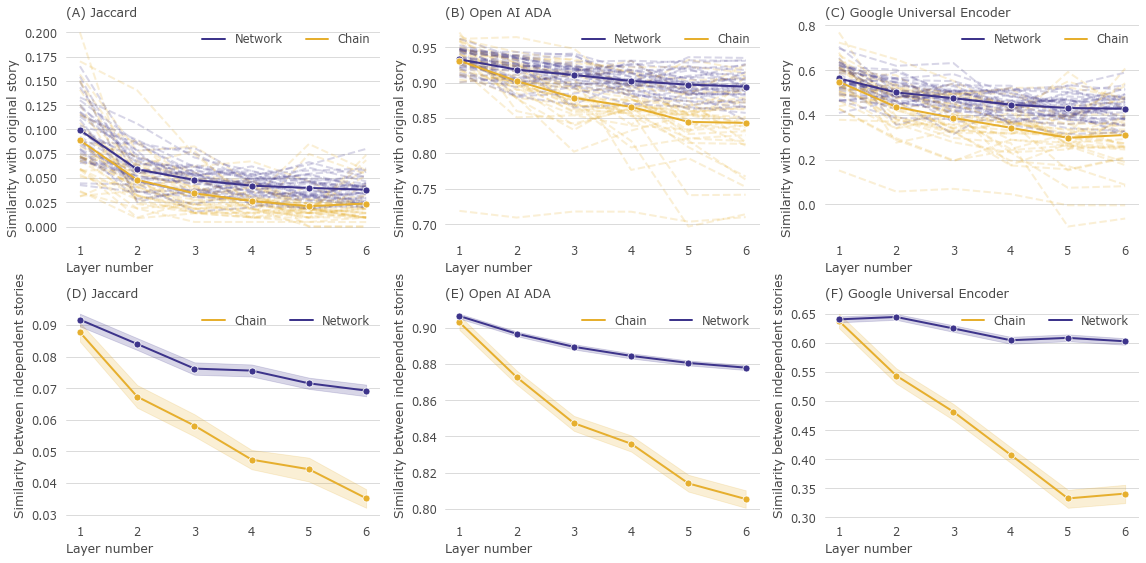

In [66]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(231)
plot_agg(results_jac, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_jac,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax1, ci=None)
set_style("Similarity with original story")
ax1.set_title("(A) Jaccard", loc="left")

ax2 = plt.subplot(232)
plot_agg(results_trans, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_trans,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax2, ci=None)
set_style("Similarity with original story")
ax2.set_title("(B) Open AI ADA", loc="left")

ax2 = plt.subplot(233)
plot_agg(results_trans_ge, x="layer_n",y="jaccard_original_story",hue="condition")
sns.lineplot(x="layer_n",y="jaccard_original_story",hue="condition",data=results_trans_ge,lw=2,marker="o",markersize=7,palette=cond2color, ax=ax2, ci=None)
set_style("Similarity with original story")
ax2.set_title("(C) Google Universal Encoder", loc="left")


ax1 = plt.subplot(234)
r1 = main_similarity_indep_replicates(results_jac,jaccard,ax=ax1)
ax1.set_title("(D) Jaccard", loc="left")

# Global embeedings from open AI
d_res = json.load(open('./data_embedding/results_openai_embeddings.json'))
ax2 = plt.subplot(235)
_1 = main_similarity_indep_replicates(results_trans,w2t_embedd,ax=ax2)
ax2.set_title("(E) Open AI ADA", loc="left")

# Global embeedings from GUE
d_res = json.load(open('./data_embedding/results_google_encoder_embeddings.json'))
ax3 = plt.subplot(236)
_2 = main_similarity_indep_replicates(results_trans_ge, w2t_embedd,ax=ax3)
ax3.set_title("(F) Google Universal Encoder", loc="left")
plt.tight_layout()

plt.savefig(f"{path_figures}/app_robustness_similarity.pdf", bbox_inches="tight")